<a href="https://colab.research.google.com/github/draftsquire/ml_labs/blob/master/Lab2/MLR_PhysCons_Pract_Kraev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physically Consistent Deep Learning

---

Краев И. Ю. ИСУ: 285659

---

In [1]:
import torch
from torch.func import jacrev, hessian, vmap
import matplotlib.pyplot as plt
import time
import numpy as np

## Task 1: ODE solution

Find $y(x)$ that satisfies $\mathcal{N}[y,x] = \frac{d^2 y}{d x^2} + y = 0$

### Prepare Data

We first prepare a dataset $\{(x,y)\}$ that satisfies the DE
The dataset has very few datapoints (to test data efficiency) and with noise (to test robustness)

In [2]:
# Generation of synthetic dataset
def generate_data(interval = (-torch.pi, torch.pi), num_samples= 1000, A = 1.0, phi = 0.0):
  X = (interval[1]-interval[0]) * torch.rand((num_samples, 1), requires_grad= True) + interval[0]

  f = lambda x : A*torch.cos(x + phi)
  Y = f(X)
  print(f"Generated dataset with {num_samples} samples, x in interval [{X.min().item():.2f}, {X.max().item():.2f}], y(x) = {A:.2f} cos(x {phi:+.2f})")

  # check if the differential equation N[y,x] = 0 holds

  ## compute first derivative (jacobian)
  df_dx = vmap(jacrev(f))
  dY_dX = df_dx(X).reshape(Y.shape)

  ## compute second derivative (hessian)
  d2f_dx2 = vmap(hessian(f))
  d2Y_dX2 = d2f_dx2(X).reshape(Y.shape)

  ## compute N[y,x]
  N = d2Y_dX2 + Y
  if torch.allclose(torch.mean(torch.square(N)), torch.tensor(0.)) :
    print("Differential equation holds")
  else:
    print("Something went wrong, Differential equation doesn't hold")
  return (X,Y)

def generate_train_test(interval_train, num_samples_train, interval_test, num_samples_test):
  A = 3* torch.rand(()) + 1 # random number between [1, 4]
  phi = 2 * torch.pi * torch.rand(()) - torch.pi # random number between [-pi, pi]
  return generate_data(interval_train, num_samples_train, A, phi), generate_data(interval_test, num_samples_test, A, phi)


# very few data points + noise
# range of test data is wider to test generalization to unseen scenarios
# 50 points for training |
(X_train, Y_train), (X_test, Y_test) = generate_train_test([-5, 5], 50, [-10, 10], 1000)
X_train += 0.1 * torch.randn_like(X_train)
Y_train += 0.1 * torch.randn_like(Y_train)

Generated dataset with 50 samples, x in interval [-4.88, 4.69], y(x) = 2.63 cos(x -1.24)
Differential equation holds
Generated dataset with 1000 samples, x in interval [-10.00, 9.97], y(x) = 2.63 cos(x -1.24)
Differential equation holds


### Prepare the model $f_{NN}(x; \theta)$ and its derivatives


- `vmap` is the vectorization map operator, it takes a function and gives a batched version of the same function. If $f: \mathbb{R} \rightarrow \mathbb{R}$. Then $\text{vmap}(f) =  f' : \mathbb{R^{n}} → \mathbb{R^{n}}$
- `jacrev` is the jacobian operator (using reverse autograd), it takes a function $f(x)$ and gives a function $\frac{\partial f}{\partial x} (x)$.
- `hessian` is the hessian operator, it takes a function $f(x)$ and gives a function $\frac{\partial^2 f}{\partial x^2} (x)$.

These functions are part of the functional API of PyTorch that is similar to JAX.

In [12]:
def get_model_and_derivatives(hidden_channels = (64, 64), activation = torch.nn.GELU, device= "cpu"):
  # construct a simple MLP
  layers = []
  inp = 1
  for h in hidden_channels:
      layers.append(torch.nn.Linear(inp, h))
      layers.append(activation())
      inp = h
  layers.append(torch.nn.Linear(inp, 1))
  model =  torch.nn.Sequential(*layers).to(device)

  # functions to compute the output and its derivatives
  # we use functions because jacrev, hessian, vmap ... requires a function and not nn.Module
  # that's why the API is called "functional"
  f = lambda x : model(x)
  df_dx = vmap(jacrev(f))
  d2f_dx2 = vmap(hessian(f))

  return (f, df_dx, d2f_dx2), model.parameters()

### Testing routine

In [ ]:
def test_model(f, X, Y):
  # simple check for f(X) vs Y,
  print(f"MSE: {torch.nn.functional.mse_loss(f(X), Y)}")
  sorted_indices = torch.argsort(X.flatten())
  X = X[sorted_indices].reshape(-1,1)
  Y = Y[sorted_indices].reshape(-1,1)
  plt.plot(X.detach().cpu(), Y.detach().cpu(), label= 'Act')
  plt.plot(X.detach().cpu(), f(X).detach().cpu(), label= 'Pred')
  plt.legend()
  plt.plot()

### Train a black-box deep learning model

t: 0.24, Epoch 100: MSE: 0.0541, LR: 0.009649
t: 0.41, Epoch 200: MSE: 0.0387, LR: 0.008644
t: 0.58, Epoch 300: MSE: 0.0375, LR: 0.007127
t: 0.73, Epoch 400: MSE: 0.0365, LR: 0.005311
t: 0.90, Epoch 500: MSE: 0.0362, LR: 0.003451
t: 1.05, Epoch 600: MSE: 0.0360, LR: 0.001809
t: 1.22, Epoch 700: MSE: 0.0360, LR: 0.000616
t: 1.38, Epoch 800: MSE: 0.0360, LR: 0.000039
t: 1.54, Epoch 900: MSE: 0.0360, LR: 0.000159
t: 1.69, Epoch 1000: MSE: 0.0359, LR: 0.000959
t: 1.85, Epoch 1100: MSE: 0.0358, LR: 0.002328
t: 2.01, Epoch 1200: MSE: 0.0372, LR: 0.004072
t: 2.18, Epoch 1300: MSE: 0.0356, LR: 0.005947
t: 2.33, Epoch 1400: MSE: 0.0356, LR: 0.007688
t: 2.52, Epoch 1500: MSE: 0.0352, LR: 0.009052
t: 2.67, Epoch 1600: MSE: 0.1416, LR: 0.009846
t: 2.83, Epoch 1700: MSE: 0.0347, LR: 0.009959
t: 2.98, Epoch 1800: MSE: 0.0344, LR: 0.009375
t: 3.15, Epoch 1900: MSE: 0.0340, LR: 0.008176
t: 3.30, Epoch 2000: MSE: 0.0336, LR: 0.006531
t: 3.47, Epoch 2100: MSE: 0.0333, LR: 0.004670
t: 3.63, Epoch 2200: M

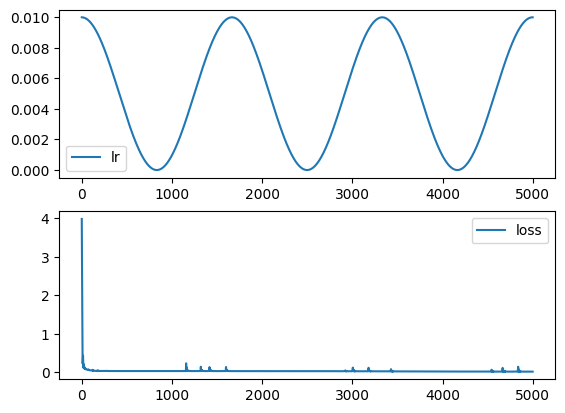

In [ ]:
lr = 0.01
num_epochs = 5000
T_scheduler = num_epochs // 6
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, _, _), params = get_model_and_derivatives(device=device)
optim = torch.optim.Adam(params, lr= lr)
# We use a CosineAnnealingLR scheduler to help avoid local minima
# it helps excite the training process which could pull the weights from
# a gradient local minima

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()

  Y_pred = f(X_train)
  loss_mse = loss_fun(Y_train, Y_pred)
  loss = loss_mse
  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time()-start_time:.2f}, Epoch {epoch+1}: MSE: {loss_mse.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.02105153538286686


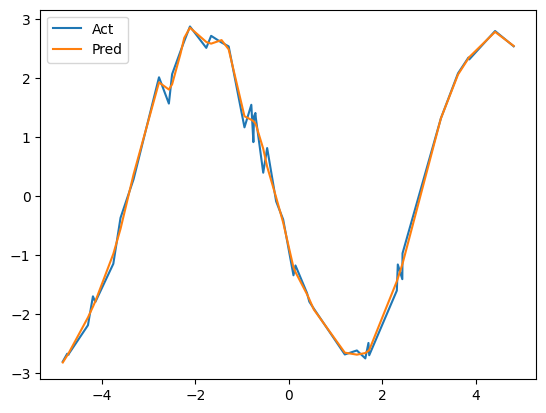

In [ ]:
test_model(f, X_train, Y_train)

MSE: 12.832085609436035


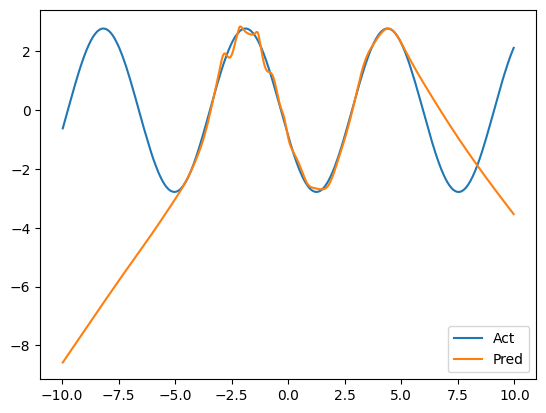

In [ ]:
test_model(f, X_test, Y_test)

We can see signs for overfitting and poor generlization

### Train a PINN deep learning model

t: 1.24, Epoch 100: MSE: 0.0447, Phys: 0.0260, LR: 0.003419
t: 2.60, Epoch 200: MSE: 0.0397, Phys: 0.0082, LR: 0.001000
t: 3.82, Epoch 300: MSE: 0.0391, Phys: 0.0015, LR: 0.009111
t: 5.06, Epoch 400: MSE: 0.0382, Phys: 0.0005, LR: 0.006400
t: 6.85, Epoch 500: MSE: 0.0382, Phys: 0.0004, LR: 0.000004
t: 9.36, Epoch 600: MSE: 0.0382, Phys: 0.0004, LR: 0.006759
t: 10.54, Epoch 700: MSE: 0.0383, Phys: 0.0014, LR: 0.008884
t: 11.72, Epoch 800: MSE: 0.0382, Phys: 0.0008, LR: 0.000784
t: 12.88, Epoch 900: MSE: 0.0382, Phys: 0.0008, LR: 0.003782
t: 14.06, Epoch 1000: MSE: 0.0382, Phys: 0.0005, LR: 0.009986


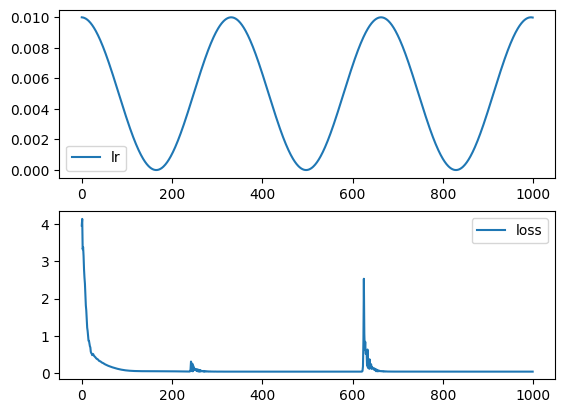

In [ ]:
lr = 0.01
num_epochs = 1000
T_scheduler = num_epochs // 6
coeff_phys = 1.0
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, _, d2f_dx2), params = get_model_and_derivatives(device=device)
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses_mse = []
losses_phys = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()
  Y_pred = f(X_train)
  loss_mse = loss_fun(Y_train, Y_pred)


  # we add a loss function for the constraint d2y_dx2 - y = 0
  d2Y_dX2_pred = d2f_dx2(X_train).reshape(-1,1)
  loss_phys = loss_fun(d2Y_dX2_pred, -Y_pred)
  #
  loss = loss_mse + coeff_phys * loss_phys
  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses_mse.append(loss_mse.item())
  losses_phys.append(loss_phys.item())
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time() - start_time:.2f}, Epoch {epoch+1}: MSE: {loss_mse.item():.4f}, Phys: {loss_phys.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.03818058595061302


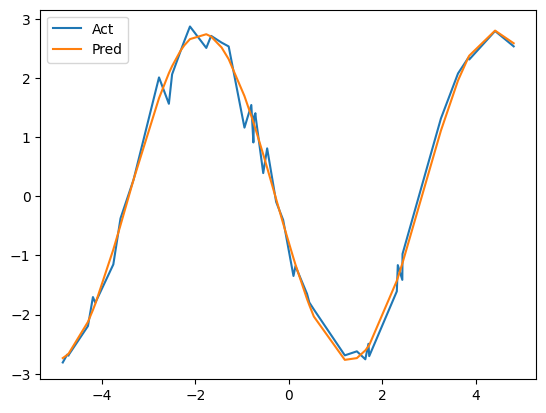

In [ ]:
test_model(f, X_train, Y_train)

MSE: 7.784757614135742


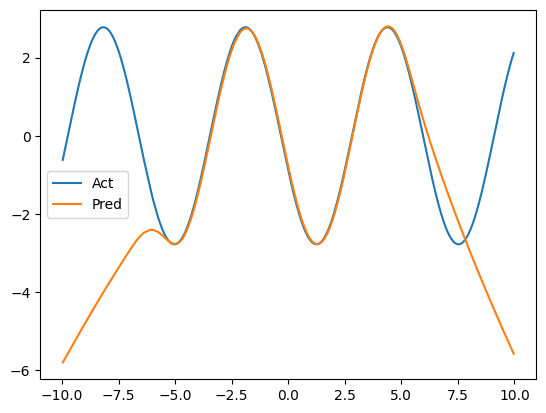

In [ ]:
test_model(f, X_test, Y_test)

We can already see that the physica loss has regulerization effect, even with noisy data, the physical constraint decreased overfitting

### Train a PINN deep learning model - 2nd try

We will use extra data points $x$ that we don't $y$ for. However, we know that $\frac{\partial^2 f}{\partial x^2}(x) - f(x) = 0$  

t: 5.68, Epoch: 100: MSE: 0.1190, Phys1: 0.0182,Phys2: 0.3358,  LR: 0.009649
t: 11.42, Epoch: 200: MSE: 0.0840, Phys1: 0.0093,Phys2: 0.2661,  LR: 0.008644
t: 16.80, Epoch: 300: MSE: 0.0774, Phys1: 0.0087,Phys2: 0.2333,  LR: 0.007127
t: 23.74, Epoch: 400: MSE: 0.0726, Phys1: 0.0083,Phys2: 0.2058,  LR: 0.005311
t: 28.99, Epoch: 500: MSE: 0.0696, Phys1: 0.0083,Phys2: 0.1873,  LR: 0.003451
t: 35.12, Epoch: 600: MSE: 0.0674, Phys1: 0.0081,Phys2: 0.1779,  LR: 0.001809
t: 40.39, Epoch: 700: MSE: 0.0662, Phys1: 0.0079,Phys2: 0.1732,  LR: 0.000616
t: 46.55, Epoch: 800: MSE: 0.0659, Phys1: 0.0078,Phys2: 0.1719,  LR: 0.000039
t: 51.77, Epoch: 900: MSE: 0.0659, Phys1: 0.0078,Phys2: 0.1717,  LR: 0.000159
t: 58.01, Epoch: 1000: MSE: 0.0653, Phys1: 0.0077,Phys2: 0.1686,  LR: 0.000959
t: 63.69, Epoch: 1100: MSE: 0.0605, Phys1: 0.0066,Phys2: 0.1781,  LR: 0.002328
t: 68.83, Epoch: 1200: MSE: 0.0649, Phys1: 0.0084,Phys2: 0.1381,  LR: 0.004072
t: 74.93, Epoch: 1300: MSE: 0.0642, Phys1: 0.0106,Phys2: 0.122

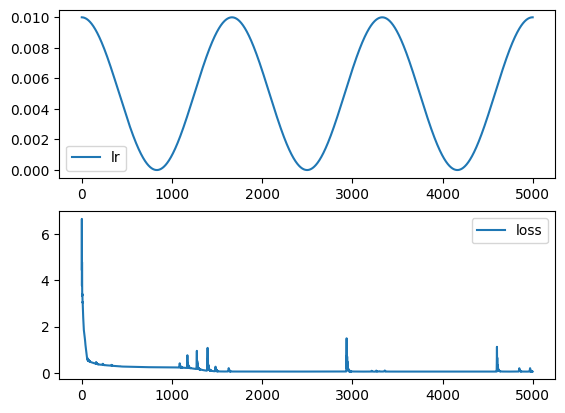

In [ ]:
lr = 0.01
num_epochs = 5000
T_scheduler = num_epochs // 6
coeff_phys1 = 1.0
coeff_phys2 = 1.0
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, _, d2f_dx2), params = get_model_and_derivatives(device=device)
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses_mse = []
losses_phys = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

# dummy data in [-10, 10] interval
X_dummy = torch.arange(-10, 10, 0.01).to(device).reshape(-1,1)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()
  Y_pred = f(X_train)
  d2Y_dX2_pred = d2f_dx2(X_train).reshape(-1,1)
  loss_mse = loss_fun(Y_train, Y_pred)
  loss_phys1 = loss_fun(d2Y_dX2_pred, -Y_pred)

  # physics loss using dummy data (no Y available)
  Y_pred_dummy = f(X_dummy)
  d2Y_dX2_pred_dummy = d2f_dx2(X_dummy).reshape(-1,1)
  loss_phys2 = loss_fun(d2Y_dX2_pred_dummy, -Y_pred_dummy)

  loss = loss_mse + coeff_phys1 * loss_phys1 + coeff_phys2 * loss_phys2

  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses_mse.append(loss_mse.item())
  losses_phys.append(loss_phys.item())
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time() - start_time:.2f}, Epoch: {epoch+1}: MSE: {loss_mse.item():.4f}, Phys1: {loss_phys1.item():.4f},Phys2: {loss_phys2.item():.4f},  LR: {scheduler.get_last_lr()[0]:.6f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.03957493230700493


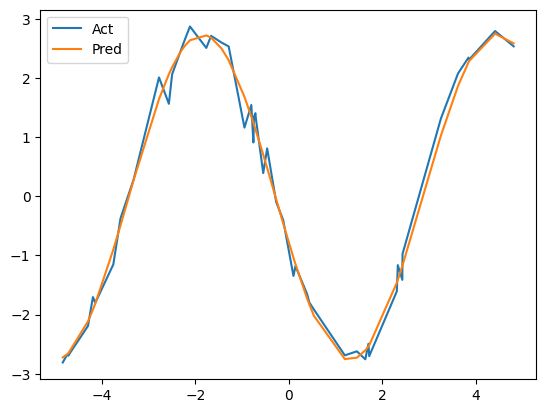

In [ ]:
test_model(f, X_train, Y_train)

MSE: 0.043439384549856186


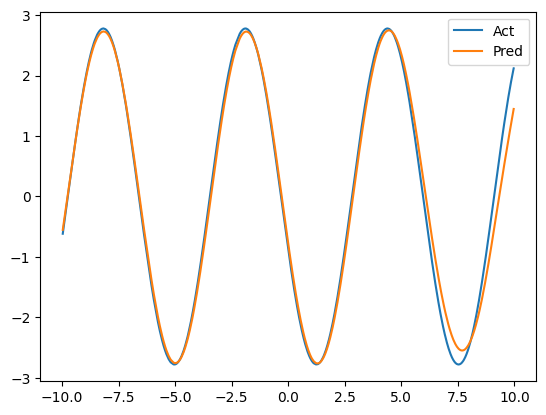

In [ ]:
test_model(f, X_test, Y_test)

We can see that even with only 50 noisy data points on [-5, 5] range, we are able to predict well outisde that range.

## HW 1:
Suggest other constraint that can be done using dummy data, something related to the periodic nature maybe?. Implement your suggestion and produce graphs. Comment on them

Periodic properties of our function are the following:

- $f(x) = f(x + 2 \pi * t), t \in [-2,-1,0,1, (...)]$  
- $f'(x) = f'(x + 2 \pi * t)$

t: 1.79, Epoch: 100: MSE: 0.6253, Phys1: 0.0527,Loss periodic dummy: 0.1197,  LR: 0.009649
t: 3.58, Epoch: 200: MSE: 0.5897, Phys1: 0.0329,Loss periodic dummy: 0.1506,  LR: 0.008644
t: 5.39, Epoch: 300: MSE: 0.5520, Phys1: 0.0223,Loss periodic dummy: 0.1778,  LR: 0.007127
t: 7.22, Epoch: 400: MSE: 0.5461, Phys1: 0.0219,Loss periodic dummy: 0.1754,  LR: 0.005311
t: 9.15, Epoch: 500: MSE: 0.5289, Phys1: 0.0248,Loss periodic dummy: 0.1752,  LR: 0.003451
t: 11.47, Epoch: 600: MSE: 0.4922, Phys1: 0.0156,Loss periodic dummy: 0.1898,  LR: 0.001809
t: 13.27, Epoch: 700: MSE: 0.4840, Phys1: 0.0140,Loss periodic dummy: 0.1929,  LR: 0.000616
t: 15.08, Epoch: 800: MSE: 0.4822, Phys1: 0.0137,Loss periodic dummy: 0.1934,  LR: 0.000039
t: 16.88, Epoch: 900: MSE: 0.4820, Phys1: 0.0137,Loss periodic dummy: 0.1935,  LR: 0.000159
t: 18.71, Epoch: 1000: MSE: 0.4781, Phys1: 0.0130,Loss periodic dummy: 0.1947,  LR: 0.000959
t: 20.56, Epoch: 1100: MSE: 0.4646, Phys1: 0.0133,Loss periodic dummy: 0.2004,  LR: 

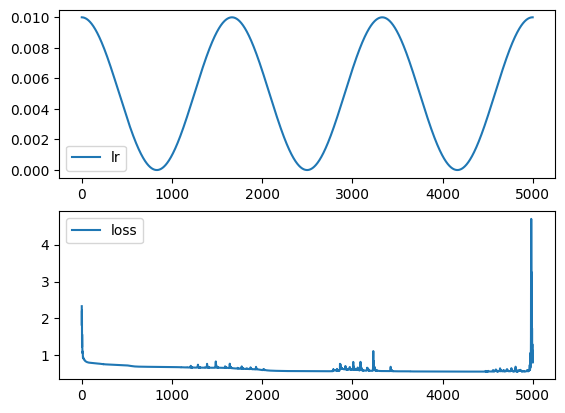

In [ ]:
lr = 0.01
num_epochs = 5000
T_scheduler = num_epochs // 6
coeff_phys1 = 1.0
coeff_phys2 = 1.0
device = "cuda"
loss_fun = torch.nn.MSELoss()
coeff_periodic = 1.0

(f, df_dx , d2f_dx2), params = get_model_and_derivatives(device=device)
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses_mse = []
losses_phys = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

# dummy data in [-10, 10] interval
X_dummy = torch.arange(-10, 10, 0.01).to(device).reshape(-1,1)
# dummy input data shifted by a period
X_dummy_shifted = X_dummy + torch.pi * 2


start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()

  Y_pred = f(X_train)
  d2Y_dX2_pred = d2f_dx2(X_train).reshape(-1,1)
  loss_mse = loss_fun(Y_train, Y_pred)
  loss_phys1 = loss_fun(d2Y_dX2_pred, -Y_pred)

  # Dummy data using periodic constraints
  Y_pred_dummy = f(X_dummy)
  Y_pred_dummy_shifted = f(X_dummy_shifted)
  dY_dX_pred_dummy = df_dx(X_dummy).reshape(-1,1)
  dY_dX_pred_dummy_shifted = df_dx(X_dummy_shifted).reshape(-1,1)
  # physics loss using dummy data (no Y available)
  # Weight of derivative loss is reduced
  loss_dummy = loss_fun(Y_pred_dummy, Y_pred_dummy_shifted) + 0.2 * loss_fun(dY_dX_pred_dummy, dY_dX_pred_dummy_shifted)
  loss = loss_mse + coeff_phys1 * loss_phys1 + loss_dummy * coeff_periodic

  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses_mse.append(loss_mse.item())
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time() - start_time:.2f}, Epoch: {epoch+1}: MSE: {loss_mse.item():.4f}, Phys1: {loss_phys1.item():.4f},Loss periodic dummy: {loss_dummy.item():.4f},  LR: {scheduler.get_last_lr()[0]:.6f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()

MSE: 0.5933576822280884


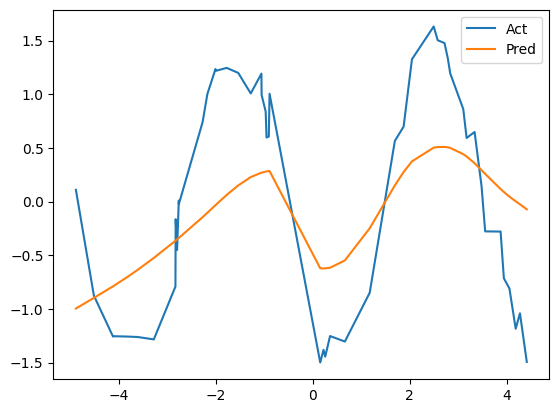

In [ ]:
test_model(f, X_train, Y_train)


MSE: 1.1855217218399048


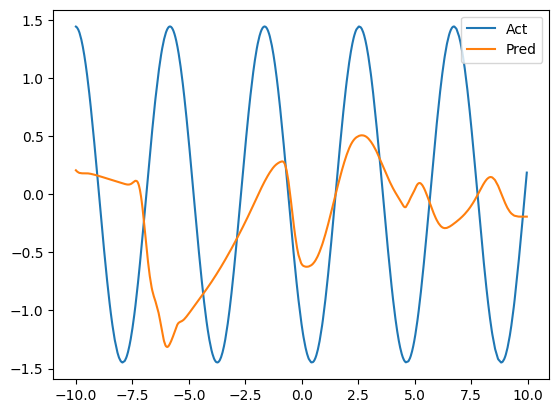

In [ ]:
test_model(f, X_test, Y_test)

Model with altered loss function, which uses periodicity of sine function looks to do good job (at least the result is not worse than previous try).

## ODE discovery
Find $y(x)$ that satisfies $\mathcal{N}[y,x; \omega] = \frac{d^2 y}{d x^2} + \omega ^2 y = 0$, $\omega$ is unknown

### Prepare Data

As before, but with different frequency $\omega = 1.5$ is unknown to the model, it should be learnt

In [ ]:
# Generation of synthetic dataset
def generate_data(interval = (-torch.pi, torch.pi), num_samples= 1000, A = 1.0, phi = 0.0, omega= 1.5):
  X = (interval[1]-interval[0]) * torch.rand((num_samples, 1), requires_grad= True) + interval[0]

  f = lambda x : A*torch.cos(omega* x + phi)
  Y = f(X)
  print(f"Generated dataset with {num_samples} samples, x in interval [{X.min().item():.2f}, {X.max().item():.2f}], y(x) = {A:.2f} cos({omega:.2f} x {phi:+.2f})")

  # check if the differential equation N[y,x] = 0 holds

  ## compute first derivative (jacobian)
  df_dx = vmap(jacrev(f))
  dY_dX = df_dx(X).reshape(Y.shape)

  ## compute second derivative (hessian)
  d2f_dx2 = vmap(hessian(f))
  d2Y_dX2 = d2f_dx2(X).reshape(Y.shape)

  ## compute N[y,x]
  N = d2Y_dX2 + omega * omega * Y
  if torch.allclose(torch.mean(torch.square(N)), torch.tensor(0.)) :
    print("Differential equation holds")
  else:
    print("Something went wrong, Differential equation doesn't hold")
  return (X,Y)
def generate_train_test(interval_train, num_samples_train, interval_test, num_samples_test, omega):
  A = 3* torch.rand(()) + 1 # random number between [1, 4]
  phi = 2 * torch.pi * torch.rand(()) - torch.pi # random number between [-pi, pi]
  return generate_data(interval_train, num_samples_train, A, phi, omega), generate_data(interval_test, num_samples_test, A, phi)


# very few data points + noise
(X_train, Y_train), (X_test, Y_test) = generate_train_test([-5, 5], 50, [-10, 10], 1000, 1.5)
X_train += 0.1 * torch.randn_like(X_train)
Y_train += 0.1 * torch.randn_like(Y_train)

Generated dataset with 50 samples, x in interval [-4.83, 4.48], y(x) = 1.45 cos(1.50 x +2.47)
Differential equation holds
Generated dataset with 1000 samples, x in interval [-10.00, 9.96], y(x) = 1.45 cos(1.50 x +2.47)
Differential equation holds


### Black Box DL model

t: 0.17, Epoch 100: MSE: 0.0511, LR: 0.009649
t: 0.33, Epoch 200: MSE: 0.0452, LR: 0.008644
t: 0.49, Epoch 300: MSE: 0.0427, LR: 0.007127
t: 0.64, Epoch 400: MSE: 0.0419, LR: 0.005311
t: 0.81, Epoch 500: MSE: 0.0413, LR: 0.003451
t: 0.97, Epoch 600: MSE: 0.0408, LR: 0.001809
t: 1.14, Epoch 700: MSE: 0.0405, LR: 0.000616
t: 1.30, Epoch 800: MSE: 0.0405, LR: 0.000039
t: 1.47, Epoch 900: MSE: 0.0405, LR: 0.000159
t: 1.62, Epoch 1000: MSE: 0.0403, LR: 0.000959
t: 1.78, Epoch 1100: MSE: 0.0398, LR: 0.002328
t: 1.95, Epoch 1200: MSE: 0.0394, LR: 0.004072
t: 2.11, Epoch 1300: MSE: 0.0389, LR: 0.005947
t: 2.28, Epoch 1400: MSE: 0.0385, LR: 0.007688
t: 2.44, Epoch 1500: MSE: 0.0377, LR: 0.009052
t: 2.61, Epoch 1600: MSE: 0.0364, LR: 0.009846
t: 2.77, Epoch 1700: MSE: 0.0356, LR: 0.009959
t: 2.93, Epoch 1800: MSE: 0.0338, LR: 0.009375
t: 3.10, Epoch 1900: MSE: 0.0327, LR: 0.008176
t: 3.31, Epoch 2000: MSE: 0.0318, LR: 0.006531
t: 3.59, Epoch 2100: MSE: 0.0313, LR: 0.004670
t: 3.78, Epoch 2200: M

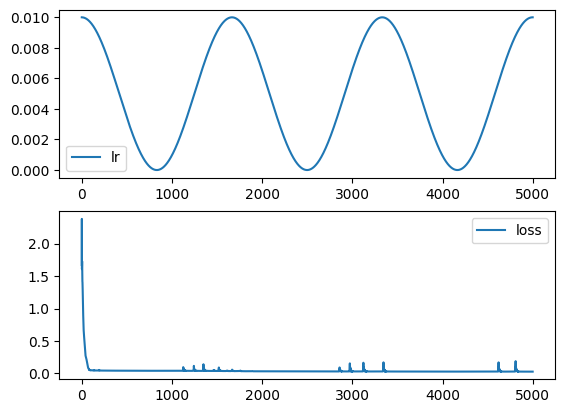

In [ ]:
lr = 0.01
num_epochs = 5000
T_scheduler = num_epochs // 6
device = "cuda"
loss_fun = torch.nn.MSELoss()

(f, _, _), params = get_model_and_derivatives(device=device)
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)


lrs = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()
  Y_pred = f(X_train)
  loss_mse = loss_fun(Y_train, Y_pred)
  loss = loss_mse
  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time()-start_time:.2f}, Epoch {epoch+1}: MSE: {loss_mse.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.027171412482857704


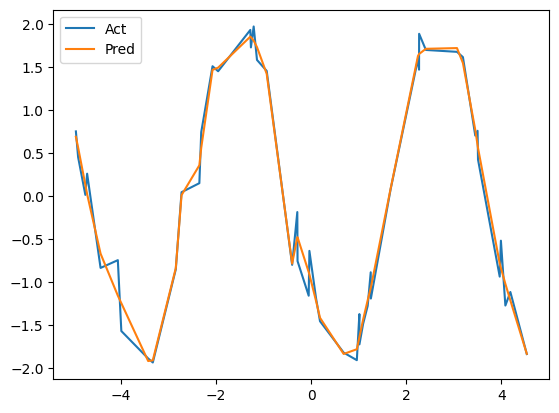

In [ ]:
test_model(f, X_train, Y_train)

MSE: 14.89725112915039


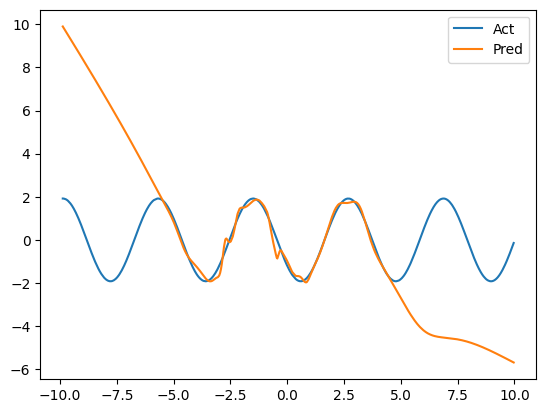

In [ ]:
test_model(f, X_test, Y_test)

We see similar behaviour as before, overfitting + poor generalization to unseen scenarios.

### PINN model: 1st try
We add a learnable parameter $\omega$.

t: 1.22, Epoch 100: MSE: 0.2186, Phys: 0.1266, LR: 0.008536, Omega: -0.86
t: 2.41, Epoch 200: MSE: 0.1007, Phys: 0.0750, LR: 0.005000, Omega: -1.23
t: 3.62, Epoch 300: MSE: 0.0851, Phys: 0.0531, LR: 0.001464, Omega: -1.29
t: 4.81, Epoch 400: MSE: 0.0823, Phys: 0.0490, LR: 0.000000, Omega: -1.30
t: 6.16, Epoch 500: MSE: 0.0793, Phys: 0.0442, LR: 0.001464, Omega: -1.31
t: 7.74, Epoch 600: MSE: 0.0916, Phys: 0.1585, LR: 0.005000, Omega: -1.35
t: 8.92, Epoch 700: MSE: 0.0700, Phys: 0.0244, LR: 0.008536, Omega: -1.41
t: 10.10, Epoch 800: MSE: 0.0757, Phys: 0.0315, LR: 0.010000, Omega: -1.41
t: 11.28, Epoch 900: MSE: 0.0562, Phys: 0.0021, LR: 0.008536, Omega: -1.47
t: 12.44, Epoch 1000: MSE: 0.0560, Phys: 0.0017, LR: 0.005000, Omega: -1.49
t: 13.60, Epoch 1100: MSE: 0.0559, Phys: 0.0015, LR: 0.001464, Omega: -1.49
t: 14.78, Epoch 1200: MSE: 0.0559, Phys: 0.0015, LR: 0.000000, Omega: -1.49
t: 15.97, Epoch 1300: MSE: 0.0559, Phys: 0.0015, LR: 0.001464, Omega: -1.49
t: 17.13, Epoch 1400: MSE: 0

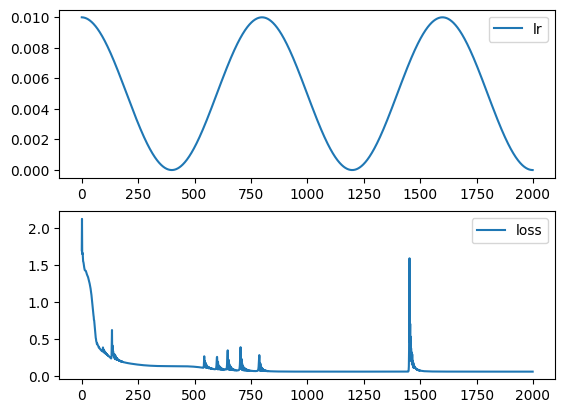

In [ ]:
# Learnable Parameter
omega_t = torch.tensor(0.01, requires_grad=True) #requires_grad is important so torch will generate gradients for this
# Adding new learnable parameter representing bias

lr = 0.01
num_epochs = 2000
T_scheduler = num_epochs // 5
coeff_phys = 1.0
device = "cuda"
loss_fun = torch.nn.MSELoss()

(f, _, d2f_dx2), params = get_model_and_derivatives(device=device)
params = [*params, omega_t] # the total set of parameters are model_parameters + omega
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses_mse = []
losses_phys = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()
  Y_pred = f(X_train)
  d2Y_dX2_pred = d2f_dx2(X_train).reshape(-1,1)
  loss_mse = loss_fun(Y_train, Y_pred)
  # attention to the loss formula taking into account omega
  loss_phys = loss_fun(d2Y_dX2_pred, -omega_t*omega_t*Y_pred)
  loss = loss_mse + coeff_phys * loss_phys
  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses_mse.append(loss_mse.item())
  losses_phys.append(loss_phys.item())
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time() - start_time:.2f}, Epoch {epoch+1}: MSE: {loss_mse.item():.4f}, Phys: {loss_phys.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}, Omega: {omega_t.item():.2f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.05573830381035805


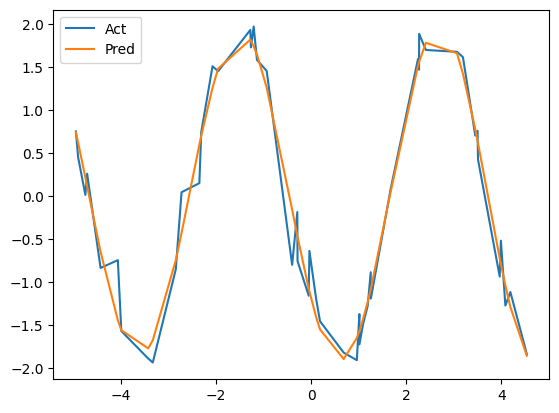

In [ ]:
test_model(f, X_train, Y_train)

MSE: 5.833486080169678


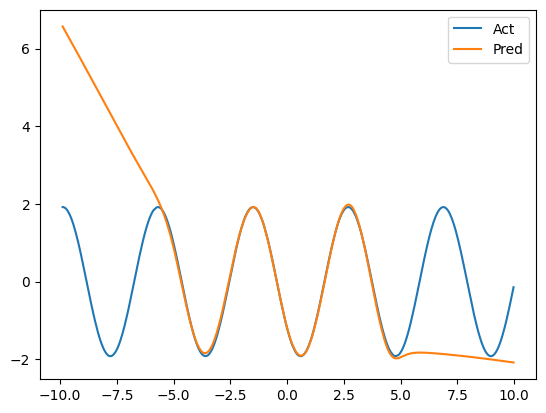

In [ ]:
test_model(f, X_test, Y_test)

## HW2:
Implement PINNs with dummy data to enhance generalization, plot graphs.
We well use the same principle that before.



t: 2.69, Epoch 100: MSE: 0.7500, Phys: 0.1504, Dummy: 0.0984, LR: 0.008536, Omega: 1.24
t: 5.12, Epoch 200: MSE: 0.2813, Phys: 0.0735, Dummy: 0.2149, LR: 0.005000, Omega: 1.41
t: 7.32, Epoch 300: MSE: 0.2047, Phys: 0.0541, Dummy: 0.2002, LR: 0.001464, Omega: 1.44
t: 9.87, Epoch 400: MSE: 0.1900, Phys: 0.0502, Dummy: 0.2031, LR: 0.000000, Omega: 1.44
t: 12.04, Epoch 500: MSE: 0.1809, Phys: 0.0476, Dummy: 0.2084, LR: 0.001464, Omega: 1.44
t: 14.50, Epoch 600: MSE: 0.1810, Phys: 0.0540, Dummy: 0.2153, LR: 0.005000, Omega: 1.43
t: 17.38, Epoch 700: MSE: 0.2018, Phys: 0.0564, Dummy: 0.2359, LR: 0.008536, Omega: 1.41
t: 20.08, Epoch 800: MSE: 0.1650, Phys: 0.0403, Dummy: 0.2151, LR: 0.010000, Omega: 1.44
t: 22.49, Epoch 900: MSE: 0.1555, Phys: 0.0399, Dummy: 0.2061, LR: 0.008536, Omega: 1.44
t: 27.34, Epoch 1000: MSE: 0.1415, Phys: 0.0292, Dummy: 0.1985, LR: 0.005000, Omega: 1.45
t: 31.43, Epoch 1100: MSE: 0.1300, Phys: 0.0258, Dummy: 0.1879, LR: 0.001464, Omega: 1.46
t: 34.32, Epoch 1200: M

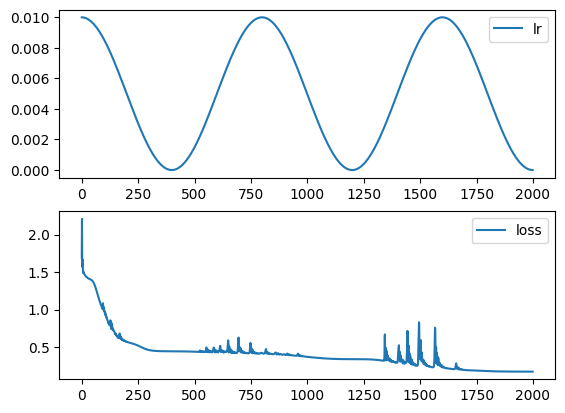

In [ ]:
# Learnable Parameter
omega_t = torch.tensor(0.01, requires_grad=True) #requires_grad is important so torch will generate gradients for this

lr = 0.01
num_epochs = 2000
T_scheduler = num_epochs // 5
coeff_phys = 1.0
coeff_dummy = 1.0
device = "cuda"
loss_fun = torch.nn.MSELoss()

(f, _, d2f_dx2), params = get_model_and_derivatives(device=device)
params = [*params, omega_t] # the total set of parameters are model_parameters + omega
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses_mse = []
losses_phys = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

# Create dummy data
X_dummy = torch.arange(-10, 10, 0.01).to(device).reshape(-1,1)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()
  Y_pred = f(X_train)
  d2Y_dX2_pred = d2f_dx2(X_train).reshape(-1,1)
  loss_mse = loss_fun(Y_train, Y_pred)

  # attention to the loss formula taking into account omega
  loss_phys = loss_fun(d2Y_dX2_pred, -omega_t*omega_t*Y_pred)
  # Physics loss on dummy data
  Y_dummy = f(X_dummy)
  d2Y_dX2_dummy = d2f_dx2(X_dummy).reshape(-1,1)
  loss_phys_dummy = loss_fun(d2Y_dX2_dummy, -omega_t*omega_t*Y_dummy)

  loss = loss_mse + coeff_phys * loss_phys + coeff_dummy * loss_phys_dummy
  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses_mse.append(loss_mse.item())
  losses_phys.append(loss_phys.item())
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time() - start_time:.2f}, Epoch {epoch+1}: MSE: {loss_mse.item():.4f}, Phys: {loss_phys.item():.4f}, Dummy: {loss_phys_dummy.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}, Omega: {omega_t.item():.2f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.07773837447166443


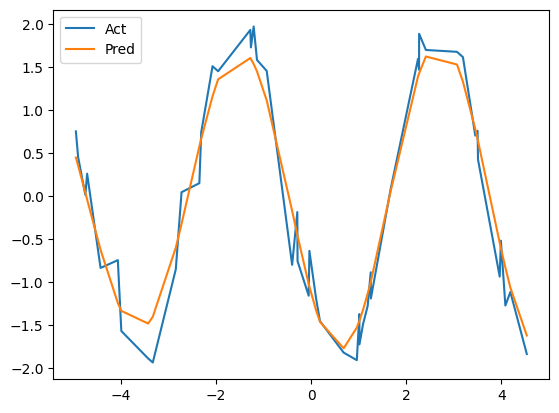

In [ ]:
test_model(f, X_train, Y_train)

MSE: 0.2194925844669342


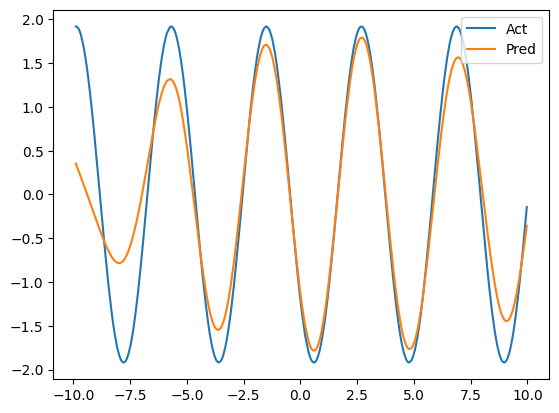

In [ ]:
test_model(f, X_test, Y_test)

We have obviously improved the generalisation effectivness of the model, but it's still far from perfect.

## HW3:

Now we explored the case of full known DE and the case of unknown frequency. Now implement the case of unknown frequency + unknown bias, something like $y(x) = A cos(\omega x + \phi) + B$. First derive the DE operator $N$ and implement PINNs to discover and solve it.  

If we take the first two derivatives we can formalize the task using N operator:
- $y(x) = A cos(\omega x + \phi) + B$
- $y'(x) = -A \omega sin(\omega x+\phi)$
- $y''(x) = -A \omega^2 cos(\omega x+\phi)$


Find $y(x)$ that satisfies $\mathcal{N}[y,x;\omega, \phi] = \frac{d^2 y}{d x^2} + (y(x) - B) \omega^2 = 0$

-------------------------

As in HW2, we will add dummy data to enchance generalization


In [13]:
# Learnable Parameter
omega_t = torch.tensor(0.01, requires_grad=True) #requires_grad is important so torch will generate gradients for this
# Add learnable parameter representing unknown bias
bias_t = torch.tensor(0.01, requires_grad=True)


lr = 0.01
num_epochs = 5000
T_scheduler = num_epochs // 5
coeff_phys = 1.0
coeff_dummy = 1.0
device = "cuda"
loss_fun = torch.nn.MSELoss()

(f, _, d2f_dx2), params = get_model_and_derivatives(device=device)
params = [*params, omega_t] # the total set of parameters are model_parameters + omega
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses_mse = []
losses_phys = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

# Create dummy data
X_dummy = torch.arange(-10, 10, 0.01).to(device).reshape(-1,1)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()
  Y_pred = f(X_train)
  d2Y_dX2_pred = d2f_dx2(X_train).reshape(-1,1)
  loss_mse = loss_fun(Y_train, Y_pred)

  # attention to the loss formula taking into account omega
  loss_phys = loss_fun(d2Y_dX2_pred, -omega_t*omega_t*(Y_pred - bias_t))
  # Physics loss on dummy data
  Y_dummy = f(X_dummy)
  d2Y_dX2_dummy = d2f_dx2(X_dummy).reshape(-1,1)
  loss_phys_dummy = loss_fun(d2Y_dX2_dummy, -omega_t*omega_t*(Y_dummy - bias_t))

  loss = loss_mse + coeff_phys * loss_phys + coeff_dummy * loss_phys_dummy
  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses_mse.append(loss_mse.item())
  losses_phys.append(loss_phys.item())
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time() - start_time:.2f}, Epoch {epoch+1}: MSE: {loss_mse.item():.4f}, Phys: {loss_phys.item():.4f}, Dummy: {loss_phys_dummy.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}, Omega: {omega_t.item():.2f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()

AttributeError: partially initialized module 'torch._dynamo' has no attribute 'external_utils' (most likely due to a circular import)

MSE: 0.03139825165271759


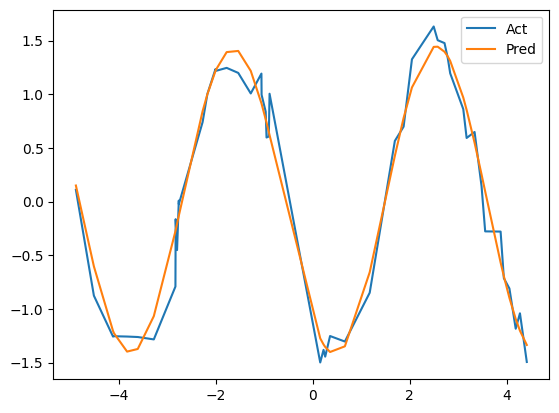

In [ ]:
test_model(f, X_train, Y_train)

MSE: 0.005807005800306797


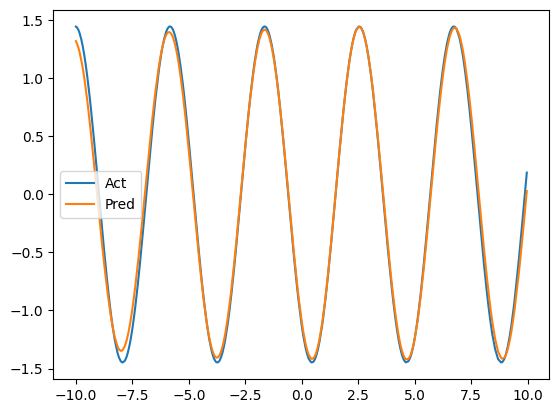

In [ ]:
test_model(f, X_test, Y_test)

## HW4:
Q: Can we use ReLU activation function in the NNs of the previous tasks? why?

-----------------

Technically, we can. I even tried and it works, though much worse than with GELU, at least with same parameters (n of epochs, learning rate, etc.) that we used.

It is not suitable though, because it has discontinuities in it's derivatives (the value of 2nd derivative of ReLU in x=0 is undefined), but in the discussed cases we are using higher-order derivatives to count loss. So it's more appropriate that we use activation functions that have "smoother" derivatives like *sigmoid*, *tanh* or *GELU* that was used in previous tasks.


## HW5:
 Following the same principles use a PINNs to learn the dynamics of simplified 2D multirotor

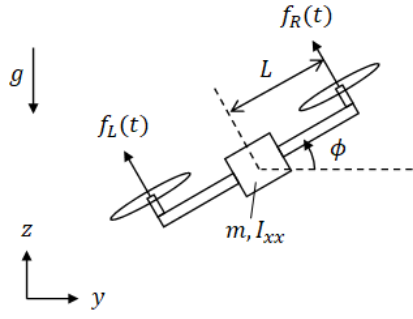

The state is $x = [y, z, \phi, v_y, v_z, \omega]$, the input is the thrust of left and right rotors $u = [f_L, f_R]$
We have the following parameters of the model (could be inaccurate)
$m = 0.35, I_{xx} = 0.005, L = 0.1, g= 9.81$

1. Derive the analytical model, define $\dot{x} = f(x, u)$.

State vector derivativative element-by-element (based on the recommended [source](https://cookierobotics.com/052/)):

\begin{align}
\dot{y} &= v_y \\
\dot{z} &= v_z \\
\dot{\phi} &= \omega \\
\dot{v_y} &= -\frac{(f_L + f_R)}{m}\sin(\phi) \\
\dot{v_z} &= \frac{(f_L + f_R)}{m}\cos(\phi) - g \\
\dot{\omega} &= \frac{L(f_R - f_L)}{I_{xx}}
\end{align}

or

\begin{align}
\dot{y} &= v_y \\
\dot{z} &= v_z \\
\dot{\phi} &= \omega \\
\ddot{y} &= -\frac{(f_L + f_R)}{m}\sin(\phi) \\
\ddot{z} &= \frac{(f_L + f_R)}{m}\cos(\phi) - g \\
\ddot{\phi} &= \frac{L(f_R - f_L)}{I_{xx}}
\end{align}

2. Create a python function to get the predicted state dynamics $\dot{x}$ based on the analytical model

In [14]:
def f_anlyt(x, u):
  m = 0.35
  I_xx = 0.005
  L = 0.1
  g = 9.81
  #####
  # put the equations here
  y = x[..., 0] # This bizarre notation used for handling baatches
  z = x[..., 1]
  phi = x[..., 2]
  v_y = x[..., 3]
  v_z = x[..., 4]
  omega = x[..., 5]

  f_l = u[..., 0]
  f_r = u[..., 1]

  d_y = v_y
  d_z = v_z
  d_phi = omega

  dd_y = - (f_l + f_r) * torch.sin(phi) / m
  dd_z = (f_l + f_r) * torch.cos(phi) / m - g
  dd_phi = L *  (f_r + f_l) / I_xx

  return torch.stack([d_y, d_z, d_phi, dd_y, dd_z, dd_phi], dim=-1)


In [6]:
# Download traing and test sets
import gdown
gdown.download('https://drive.google.com/file/d/1mdCwjWupljOQH4ySLUxuTytD1Hsrzfho/view?usp=sharing', fuzzy= True)
gdown.download('https://drive.google.com/file/d/1LngllwyXvPtWD7vB-cceaFibf0UDY7N4/view?usp=sharing', fuzzy= True)

import pandas as pd

df = pd.read_csv('train.csv')

x = df[['y', 'z', 'phi', 'vy', 'vz', 'omega']].values
u = df[['ul', 'ur']].values

x_next = df[['y_next', 'z_next', 'phi_next', 'vy_next', 'vz_next', 'omega_next']].values
u_next = df[['ul_next', 'ur_next']].values

xu = np.concatenate([x, u], axis=1)
dxu = np.concatenate([x_next - x, u_next - u], axis=1)

X_train = torch.tensor(xu, dtype=torch.float32)
dX_train = torch.tensor(dxu, dtype=torch.float32)
Y_train = torch.tensor(x_next, dtype=torch.float32)

# incuce noise
X_train += 0.1 * torch.randn_like(X_train)
Y_train += 0.1 * torch.randn_like(Y_train)

# decrease number of samples
frac_samples = 10
X_train = X_train[::frac_samples]
dX_train = dX_train[::frac_samples]
Y_train = Y_train[::frac_samples]

df_test = pd.read_csv('test.csv')

x = df_test[['y', 'z', 'phi', 'vy', 'vz', 'omega']].values
u = df_test[['ul', 'ur']].values
x_next = df_test[['y_next', 'z_next', 'phi_next', 'vy_next', 'vz_next', 'omega_next']].values
xu = np.concatenate([x, u], axis=1)

X_test = torch.tensor(xu, dtype=torch.float32)
Y_test = torch.tensor(x_next, dtype=torch.float32)

X_train.shape, dX_train.shape, Y_train.shape, X_test.shape, Y_test.shape

Downloading...
From: https://drive.google.com/uc?id=1mdCwjWupljOQH4ySLUxuTytD1Hsrzfho
To: /content/train.csv
100%|██████████| 17.3M/17.3M [00:00<00:00, 133MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LngllwyXvPtWD7vB-cceaFibf0UDY7N4
To: /content/test.csv
100%|██████████| 334k/334k [00:00<00:00, 100MB/s]


(torch.Size([5000, 8]),
 torch.Size([5000, 8]),
 torch.Size([5000, 6]),
 torch.Size([999, 8]),
 torch.Size([999, 6]))

3. Create a deep learning model that predict the next state $x_{k+1} = f_{NN}(x_k, u_k)$

In [24]:
class ModelMultirotor2d(torch.nn.Module):
  def __init__(self, hidden_size=128):
    super().__init__()
    self.net = torch.nn.Sequential(
      torch.nn.Linear(8, hidden_size), #input consist of 6 state variables + 2 conrtol (u(t))
      torch.nn.Sigmoid(),
      torch.nn.Linear(hidden_size, hidden_size),
      torch.nn.Sigmoid(),
      torch.nn.Linear(hidden_size, hidden_size),
      torch.nn.Sigmoid(),
      torch.nn.Linear(hidden_size, hidden_size),
      torch.nn.Sigmoid(),
      torch.nn.Linear(hidden_size, 6) #output is state vector only
    )
  def forward(self, x, u):
    # Combine state and input into single vector
    xu = torch.cat([x, u], dim=-1)
    # Predict next state
    x_next = self.net(xu)
    return x_next



4. Create the learning pipeline with the loss:

$\mathcal{L}_{d} = \frac{1}{N-1}\sum_{k=2}^{N}{\|f_{NN}(x_{k-1},
				            u_{k-1}; \theta) - x_{k}\|^2}$

$\mathcal{L}_{ph} = \frac{1}{N-1}\sum_{k=2}^{N}{\| \frac{\partial
					            f_{NN}}{\partial x}(x_k, u_k; \theta) \Delta x_k + \frac{\partial
					            f_{NN}}{\partial u}(x_k, u_k; \theta) \Delta u_k - f_{anlt}(x_k, u_k) \Delta
				            t\|^2}$

 $\mathcal{L} = \mathcal{L}_{d} + \gamma \mathcal{L}_{ph}$

Train the model on the train dataset


t: 0.20, Epoch 10: Total Loss: 0.6906, Phys Loss: 0.0789, Data Loss: 0.6275
t: 0.36, Epoch 20: Total Loss: 0.6804, Phys Loss: 0.0789, Data Loss: 0.6173
t: 0.54, Epoch 30: Total Loss: 0.6496, Phys Loss: 0.0788, Data Loss: 0.5865
t: 0.69, Epoch 40: Total Loss: 0.4643, Phys Loss: 0.0789, Data Loss: 0.4012
t: 0.86, Epoch 50: Total Loss: 0.2310, Phys Loss: 0.0800, Data Loss: 0.1669
t: 1.02, Epoch 60: Total Loss: 0.1974, Phys Loss: 0.0793, Data Loss: 0.1340
t: 1.18, Epoch 70: Total Loss: 0.1764, Phys Loss: 0.0792, Data Loss: 0.1131
t: 1.35, Epoch 80: Total Loss: 0.1644, Phys Loss: 0.0792, Data Loss: 0.1010
t: 1.52, Epoch 90: Total Loss: 0.1604, Phys Loss: 0.0791, Data Loss: 0.0971
t: 1.68, Epoch 100: Total Loss: 0.1573, Phys Loss: 0.0792, Data Loss: 0.0940
t: 1.84, Epoch 110: Total Loss: 0.1555, Phys Loss: 0.0792, Data Loss: 0.0921
t: 2.01, Epoch 120: Total Loss: 0.1535, Phys Loss: 0.0792, Data Loss: 0.0902
t: 2.18, Epoch 130: Total Loss: 0.1524, Phys Loss: 0.0792, Data Loss: 0.0890
t: 2.34,

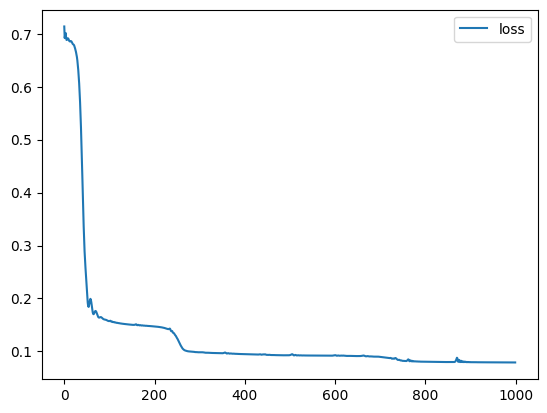

In [25]:
planar_quadrotor = ModelMultirotor2d()


lr = 0.002
num_epochs = 1000
coeff_phys = 0.8
dt = 0.01 # timestep
device = "cuda"
loss_fun = torch.nn.MSELoss()


optim = torch.optim.Adam(planar_quadrotor.parameters(), lr=lr)

jac_x = vmap(jacrev(planar_quadrotor, argnums=0))
jac_u = vmap(jacrev(planar_quadrotor, argnums=1))



X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)
dX_train = dX_train.to(device)
planar_quadrotor = planar_quadrotor.to(device)

start_time = time.time()

losses_mse = []
losses_phys = []
losses = []
for epoch in range(num_epochs):
  optim.zero_grad()

  Y_pred = planar_quadrotor(X_train[:, :6], X_train[:, 6:]) # Note that Y_pred is actually predicted state vector (X) that can be completely observed
  loss_mse_data = loss_fun(Y_train, Y_pred)

  #Extract state and input differences from provided data
  dx = dX_train[:, :6]
  du = dX_train[:, 6:]

  jac_x_val = jac_x(X_train[:, :6], X_train[:, 6:])
  jac_u_val = jac_u(X_train[:, :6], X_train[:, 6:])


  # torch.bmm is a matrix product for batches
  # Here we make physics - based prediction using model data (jacobian functions are extracted from the model)
  Y_pred_phys = torch.bmm(jac_x_val, dx.unsqueeze(-1)).squeeze(-1) + torch.bmm(jac_u_val, du.unsqueeze(-1)).squeeze(-1)
  # And the same using provided train data and pre-defined analytical function
  Y_analyt = f_anlyt(X_train[:, :6], X_train[:, 6:]) * dt # f_anlyt gives us first derivatives

  loss_phys =  loss_fun(Y_analyt, Y_pred_phys)
  loss = loss_mse_data + coeff_phys * loss_phys

  loss.backward(retain_graph= True)
  optim.step()

  losses_mse.append(loss_mse_data.item())
  losses_phys.append(loss_phys.item())
  losses.append(loss.item())
  if (epoch + 1) % 10 == 0:
    print(f"t: {time.time() - start_time:.2f}, Epoch {epoch+1}: Total Loss: {loss.item():.4f}, Phys Loss: {loss_phys.item():.4f}, Data Loss: {loss_mse_data.item():.4f}")

# plt.subplot(2, 1, 1)
# plt.plot(lrs, label= 'lr')
# plt.legend()
# plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()

5. comapre between the analytical model and the trained model on the test dataset

Neural Network MSE: 0.139814
Analytical Model MSE: 0.485340


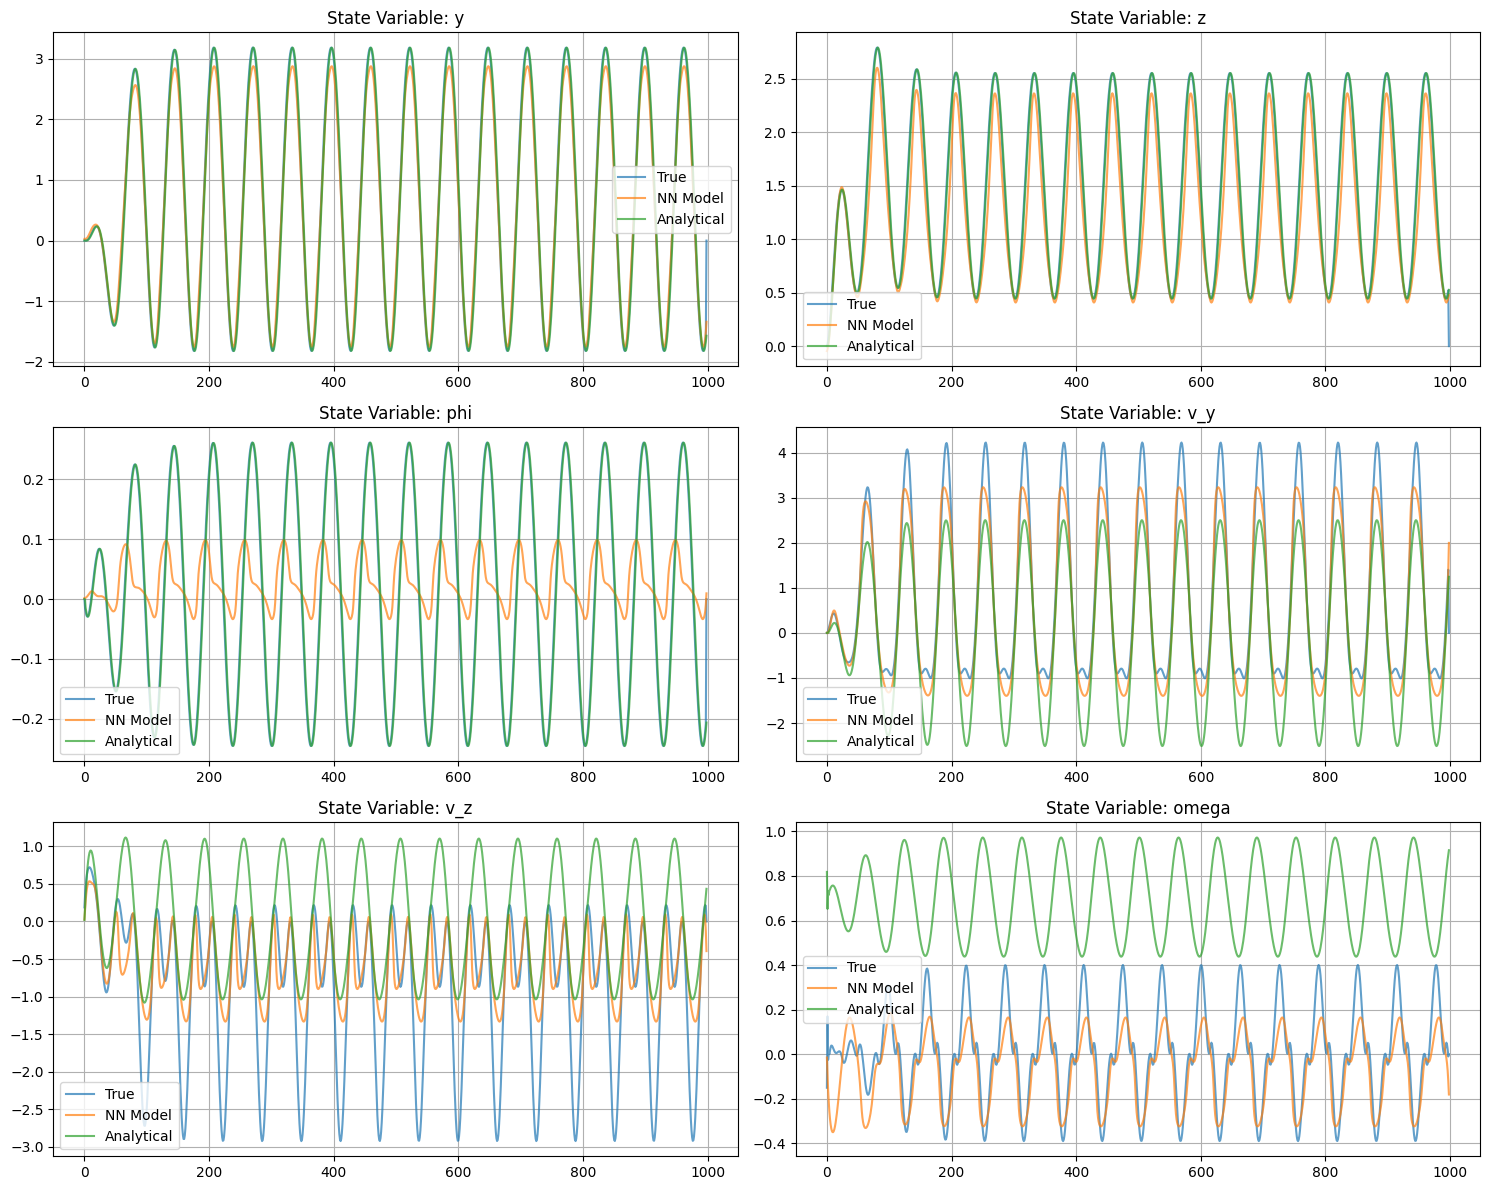

In [28]:
# Evaluate models on test data
with torch.inference_mode():
    # Neural network predictions
    nn_predictions = planar_quadrotor(X_test[:, :6], X_test[:, 6:])

    # Analytical model predictions
    analytical_predictions = X_test[:, :6] + f_anlyt(X_test[:, :6], X_test[:, 6:]) * dt

    # Compute MSE for both models
    nn_mse = torch.mean((nn_predictions - Y_test)**2)
    analytical_mse = torch.mean((analytical_predictions - Y_test)**2)

    print(f"Neural Network MSE: {nn_mse:.6f}")
    print(f"Analytical Model MSE: {analytical_mse:.6f}")

# Plot comparisons
state_labels = ['y', 'z', 'phi', 'v_y', 'v_z', 'omega']
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i in range(6):
    axes[i].plot(Y_test[:, i].cpu().numpy(), label='True', alpha=0.7)
    axes[i].plot(nn_predictions[:, i].cpu().numpy(), label='NN Model', alpha=0.7)
    axes[i].plot(analytical_predictions[:, i].cpu().numpy(), label='Analytical', alpha=0.7)
    axes[i].set_title(f'State Variable: {state_labels[i]}')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()